In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import os
import tensorflow as tf
import numpy as np
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# https://www.tensorflow.org/tutorials/load_data/images
AUTOTUNE = tf.data.experimental.AUTOTUNE

# data
data_dir = pathlib.Path("../data/raw")

# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [4]:
image_files = list(data_dir.glob("Tomato*/*.JPG"))
image_count = len(image_files)

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
STEPS_PER_EPOCH = np.ceil(image_count / BATCH_SIZE)

In [6]:
def get_class_name(item):
    return item.name.split("___")[1]

In [7]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob("Tomato*")])

In [8]:
CLASS_NAMES

array(['Tomato___Early_blight', 'Tomato___healthy',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Leaf_Mold',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Tomato_mosaic_virus', 'Tomato___Target_Spot',
       'Tomato___Septoria_leaf_spot', 'Tomato___Late_blight',
       'Tomato___Bacterial_spot'], dtype='<U45')

Early_blight


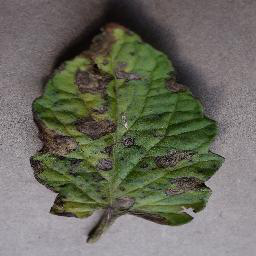

Early_blight


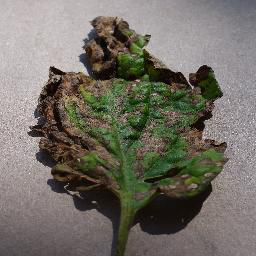

Early_blight


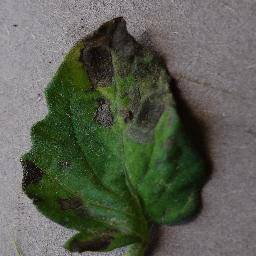

In [9]:
for image_path in image_files[:3]:
    print(get_class_name(image_path.parent))
    display.display(Image.open(str(image_path)))

In [10]:
image_path = image_files[0]

In [11]:
image_path.parent.name

'Tomato___Early_blight'

In [12]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))


Found 18160 images belonging to 10 classes.


In [13]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'Tomato*/*'))

In [14]:
for f in list_ds.take(5):
    print(f.numpy())

b'../data/raw/Tomato___Spider_mites Two-spotted_spider_mite/19cc2f74-637b-40be-9b94-615c0e0316c3___Com.G_SpM_FL 1544.JPG'
b'../data/raw/Tomato___Spider_mites Two-spotted_spider_mite/82306885-f863-4d0c-983b-9c479a0ff83f___Com.G_SpM_FL 9478.JPG'
b'../data/raw/Tomato___Tomato_Yellow_Leaf_Curl_Virus/a5416516-80f0-4004-88f6-186b79696707___UF.GRC_YLCV_Lab 01840.JPG'
b'../data/raw/Tomato___Bacterial_spot/9a124e24-d9d2-43f3-b2b9-968e4422744c___GCREC_Bact.Sp 5998.JPG'
b'../data/raw/Tomato___Early_blight/ef68398c-ec92-4e44-961a-5ec1a29d3c28___RS_Erly.B 9620.JPG'


In [15]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [16]:
file_paths = [f for f in list_ds.take(5)]

In [17]:
file_path = file_paths[0]

In [18]:
get_label(file_path)

<tf.Tensor: id=114, shape=(10,), dtype=bool, numpy=
array([False, False, False, False, False, False, False,  True, False,
       False])>

In [19]:
parts = tf.strings.split(file_path, os.path.sep)

In [21]:
print(file_path)
parts[-2]

tf.Tensor(b'../data/raw/Tomato___Septoria_leaf_spot/daad8307-4482-4a22-bbd5-395fc6d767c6___Matt.S_CG 6637.JPG', shape=(), dtype=string)


<tf.Tensor: id=180, shape=(), dtype=string, numpy=b'Tomato___Septoria_leaf_spot'>

In [22]:
CLASS_NAMES

array(['Tomato___Early_blight', 'Tomato___healthy',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Leaf_Mold',
       'Tomato___Spider_mites Two-spotted_spider_mite',
       'Tomato___Tomato_mosaic_virus', 'Tomato___Target_Spot',
       'Tomato___Septoria_leaf_spot', 'Tomato___Late_blight',
       'Tomato___Bacterial_spot'], dtype='<U45')

In [23]:
file_path

<tf.Tensor: id=46, shape=(), dtype=string, numpy=b'../data/raw/Tomato___Septoria_leaf_spot/daad8307-4482-4a22-bbd5-395fc6d767c6___Matt.S_CG 6637.JPG'>

In [24]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("Label (encoded): ", label.numpy().astype(int))

Image shape:  (256, 256, 3)
Label:  [False False  True False False False False False False False]
Label (encoded):  [0 0 1 0 0 0 0 0 0 0]


In [27]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
          ds = ds.cache(cache)
        else:
          ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [101]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

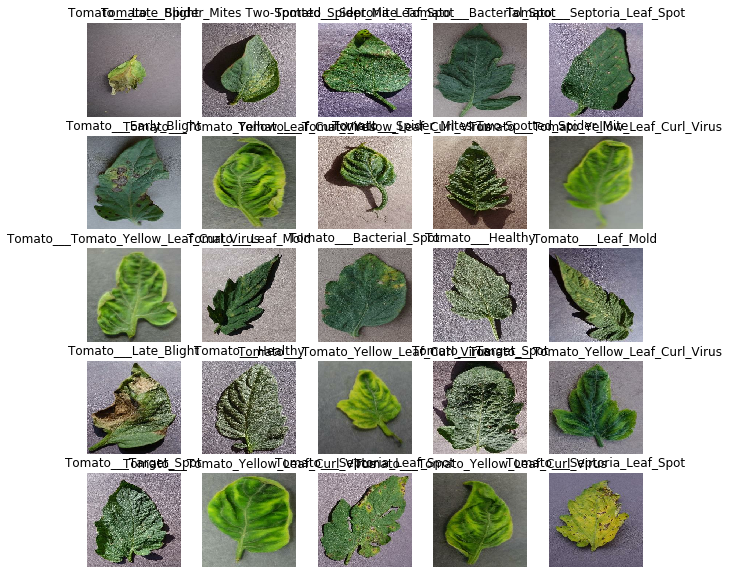

In [105]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [110]:
features_dataset = tf.data.Dataset.from_tensor_slices(image_batch)

In [127]:
subset = [f for f in features_dataset.take(5)]

In [121]:
f == image_batch[0]j

<tf.Tensor: id=710, shape=(256, 256, 3), dtype=bool, numpy=
array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ...,

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ...,
        [ True,  

## References

* https://www.tensorflow.org/tutorials/load_data/tfrecord
* https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
* https://www.tensorflow.org/datasets/catalog/overview
* https://www.tensorflow.org/guide/data
* https://www.tensorflow.org/tutorials/images/classification
* https://jkjung-avt.github.io/tfrecords-for-keras/

In [28]:
help(tf.keras.Sequential)

Help on class Sequential in module tensorflow.python.keras.engine.sequential:

class Sequential(tensorflow.python.keras.engine.training.Model)
 |  Sequential(layers=None, name=None)
 |  
 |  Linear stack of layers.
 |  
 |  Arguments:
 |      layers: list of layers to add to the model.
 |  
 |  Example:
 |  
 |  ```python
 |  # Optionally, the first layer can receive an `input_shape` argument:
 |  model = Sequential()
 |  model.add(Dense(32, input_shape=(500,)))
 |  # Afterwards, we do automatic shape inference:
 |  model.add(Dense(32))
 |  
 |  # This is identical to the following:
 |  model = Sequential()
 |  model.add(Dense(32, input_dim=500))
 |  
 |  # And to the following:
 |  model = Sequential()
 |  model.add(Dense(32, batch_input_shape=(None, 500)))
 |  
 |  # Note that you can also omit the `input_shape` argument:
 |  # In that case the model gets built the first time you call `fit` (or other
 |  # training and evaluation methods).
 |  model = Sequential()
 |  model.add(Dense

In [29]:
from src.models.train_model import model

In [30]:
m = model(10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0

In [36]:
m.input

<tf.Tensor 'conv2d_input:0' shape=(None, 256, 256, 3) dtype=float32>

In [37]:
m.output

<tf.Tensor 'dense_1/Identity:0' shape=(None, 10) dtype=float32>

In [103]:
def _parse_function(proto):
    # define your tfrecord again. Remember that you saved your image as a string.
    keys_to_features = {'image': tf.io.FixedLenFeature([], tf.string),
                        "label": tf.io.FixedLenFeature([], tf.int64)}
    
    # Load one example
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    
    # Turn your saved image string into an array
    parsed_features['image'] = tf.image.decode_jpeg(parsed_features['image'],)
    
    return parsed_features['image'], parsed_features["label"]

# https://www.tensorflow.org/tutorials/load_data/tfrecord#walkthrough_reading_and_writing_image_data
def _parse_fn(image_string):
    image_shape = tf.image.decode_jpeg(image_string)
    feature = {
      'height': _int64_feature(image_shape[0]),
      'width': _int64_feature(image_shape[1]),
      'depth': _int64_feature(image_shape[2]),
      'label': _int64_feature(label),
      'image_raw': _bytes_feature(image_string),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [156]:
# Convert Image Data to TFREcord
from src.data.image_processing import preprocess_image, load_image

# Set filename
filename = str(image_paths[0])

# load data in numpy
image_string = open(filename, "rb").read()
# image_array = tf.keras.preprocessing.image.img_to_array(image)
label = 1

# Define the features of your tfrecord
feature = {'image':  _bytes_feature(tf.compat.as_bytes(image_string)),
           'label':  _int64_feature(int(label))}

# Serialize to string and write to file
example = tf.train.Example(features=tf.train.Features(feature=feature))

record_file = "image.tfrecords"
with tf.io.TFRecordWriter(record_file) as writer:
    writer.write(example.SerializeToString())

In [157]:
raw_image_dataset = tf.data.TFRecordDataset(record_file)

# Create a dictionary describing the features.
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {image: (), label: ()}, types: {image: tf.string, label: tf.int64}>

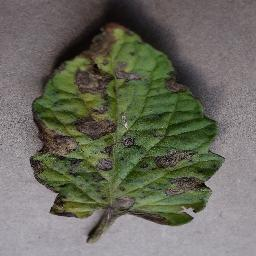

In [169]:
for image_features in parsed_image_dataset:
    image_data = image_features["image"].numpy()
    display.display(display.Image(image_data))

In [167]:
data = [f for f in parsed_image_dataset]

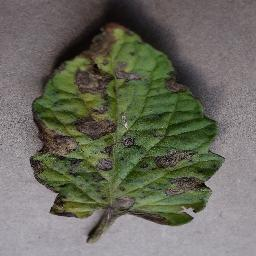

In [168]:
display.Image(data[0]["image"].numpy())